<hr style="border:2px solid #0176DE"> </hr>
<center><h1 style="color:#173F8A;"> EMI 2024 - CMM Chile</h1></center>
<hr style="border:2px solid #0176DE"> </hr>
<h3 style="color:#173F8A;text-align:right;"> Profesores: &nbsp;Nicolás Barnafi<br>Manuel A. Sánchez<br></h3>

<h3 style="color:#03122E;text-align:right;"> 
    Centro de Modelamiento Matemático <br> 
    Instituto de Ingeniería Matemática y Computacional - IMC UC<br>  
</h3>

<hr style="border:2px solid #03122E"> </hr>
<center><h1 style="color:#173F8A;"> Módulo 3: The Conjugate Gradient Method - NGSolve</h1></center> 
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC:
Primaria:
celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 
Secundaria
gris oscuro: #707070
-->

In [25]:
from ngsolve import *
from ngsolve.webgui import Draw
from ngsolve.la import EigenValues_Preconditioner
import matplotlib.pyplot as plt
import numpy as np

## TEST 1: Model Problem the $L^2$ projection

We will test the algorithm with the solution of $L^2$ projection onto the space of continuous piecewise linear functions in $(0,1)^2$ of a function
$$ f= \sin(\pi(x-y)) $$ 

In [26]:
# Solution
mesh = Mesh(unit_square.GenerateMesh(maxh=0.05))
fes = H1(mesh, order=1)
u, v = fes.TnT()
a = BilinearForm(u*v*dx).Assemble()
f = sin(2*pi*(x-y))*cos(2*pi*(x+y))
b = LinearForm(f*v*dx).Assemble()
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs())*b.vec
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [27]:
def SetL2Proj(mesh, fun=1,p=1, condense=False):
    # H1-conforming Finite Element Space
    fes = H1(mesh, order=p)
    # Trial and Test Functions
    u, v = fes.TnT()
    # Bilinear form 
    a = BilinearForm(fes, symmetric=True, condense=condense)
    a += (u*v)*dx 
    # Linear form
    b = LinearForm(fun*v*dx)
    # Gridfunction
    gfu = GridFunction(fes)
    return fes, a, b, gfu

In [28]:
def SolveL2ProjDirect(a, b, gfu, fes, condense=False):
    a.Assemble()
    b.Assemble()
    # Direct solver
    inv = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=condense))
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    return gfu, fes.ndof

In [29]:
def SolveL2ProjIterativeCG(a, b, gfu, fes, condense=False, compute_condnum=False):
    a.Assemble()
    b.Assemble()
    preI = Projector(mask=fes.FreeDofs(coupling=condense), range=True)
    inv = CGSolver(a.mat, pre=preI, maxsteps=10000)
    
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    if compute_condnum is False:
        return gfu, inv.GetSteps()
    else:
        lams = EigenValues_Preconditioner(mat=a.mat, pre=preI)
        kappa = max(lams)/min(lams)
        return gfu, ((inv.GetSteps(), kappa))

### Test 1: parameters

In [30]:
# parametros
paramt1 = dict()
paramt1['h'] = 0.05
paramt1['f'] = sin(2*pi*(x-y))*cos(2*pi*(x+y))
paramt1['p'] = 1
paramt1['levels'] = 6 # <=8 for p=1
paramt1['h0'] = 0.05
paramt1['condense'] = False

In [31]:
mesh = Mesh(unit_square.GenerateMesh(maxh=paramt1['h']))
fes, a, b, gfu = SetL2Proj(mesh, p=paramt1['p'], fun=paramt1['f'], condense=paramt1['condense'])
gfu_direct, steps = SolveL2ProjDirect(a, b, gfu, fes, condense=paramt1['condense'])
gfu_cg, steps = SolveL2ProjIterativeCG(a, b, gfu, fes, condense=paramt1['condense'], compute_condnum=True)
print(f"number steps of CG iteration: {steps}")

number steps of CG iteration: (27, 17.01776081826406)


In [32]:
Draw(gfu_direct)
Draw(gfu_cg)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [33]:
from time import time

def SolveL2ProjDirect_levels(h, levels, condense=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetL2Proj(mesh, p=paramt1['p'], fun=paramt1['f'], condense=condense)
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            SolveL2ProjDirect(a, b, gfu, fes, condense=condense)
        print (f"ndof = {fes.ndof}, time = {time()-start}")
        steps.append ( (fes.ndof, time()-start) )
    return gfu, steps

_, time_direct = SolveL2ProjDirect_levels(h=paramt1['h0'], levels=paramt1['levels'], condense=paramt1['condense'])

ndof = 514, time = 0.00878000259399414
ndof = 1973, time = 0.008830785751342773
ndof = 7729, time = 0.05845952033996582
ndof = 30593, time = 0.13978004455566406
ndof = 121729, time = 0.721015453338623
ndof = 485633, time = 4.972909688949585


In [34]:
def SolveL2ProjIterativeCG_levels(h, levels, condense=False, compute_condnum=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetL2Proj(mesh, p=paramt1['p'], fun=paramt1['f'], condense=condense)
    tiempo = []
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            
            gfu, invsteps = SolveL2ProjIterativeCG(a, b, gfu, fes, condense=condense, compute_condnum=compute_condnum)
            print (f"ndof = {fes.ndof}, time = {time()-start}, steps = {invsteps}")
            tiempo.append ( (fes.ndof, time()-start ))
        steps.append ( (fes.ndof, invsteps ))
    return gfu, tiempo, steps

_, time_cg, steps = SolveL2ProjIterativeCG_levels(h=paramt1['h0'], levels=paramt1['levels'], condense=paramt1['condense'], compute_condnum=False)

ndof = 514, time = 0.001445770263671875, steps = 27
ndof = 1973, time = 0.002898693084716797, steps = 32
ndof = 7729, time = 0.007969141006469727, steps = 35
ndof = 30593, time = 0.024163484573364258, steps = 35
ndof = 121729, time = 0.12386035919189453, steps = 36
ndof = 485633, time = 0.5826513767242432, steps = 36


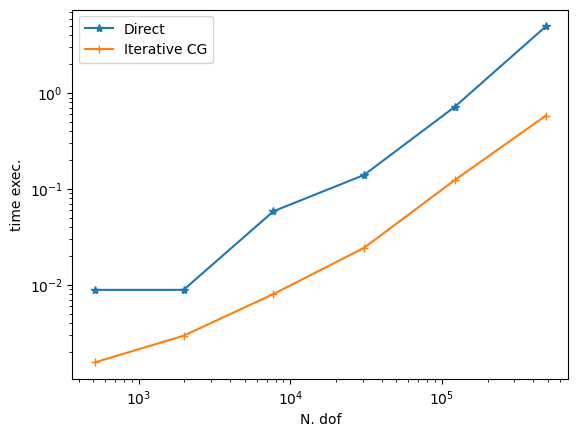

In [35]:
plt.xscale("log")
plt.yscale("log")
plt.plot(*zip(*time_direct), "-*")
plt.plot(*zip(*time_cg), "-+")
plt.legend(['Direct', 'Iterative CG'])
plt.xlabel('N. dof')
plt.ylabel('time exec.')
# plt.savefig('03_Module_Test1.png')
plt.show()

# from IPython.display import Image
# Image(filename='03_Module_Test1.png') 

In [36]:
_, _, steps = SolveL2ProjIterativeCG_levels(h=paramt1['h0'], levels=paramt1['levels'], condense=paramt1['condense'], compute_condnum=True)
ndofs = [steps[j][0] for j in range(len(steps))]
nsteps = [steps[j][1][0] for j in range(len(steps))]
kappas = [steps[j][1][1] for j in range(len(steps))]
import pandas as pd
tab = pd.DataFrame({'ndof':ndofs, 'time':np.asarray(time_cg)[:,1], 'Condition number':kappas, 'number of CG iterations': nsteps})
tab     

ndof = 514, time = 0.002930879592895508, steps = (27, 17.040048923308554)
ndof = 1973, time = 0.0042765140533447266, steps = (32, 17.11489212385365)
ndof = 7729, time = 0.009887933731079102, steps = (35, 18.442516695611047)
ndof = 30593, time = 0.03402304649353027, steps = (35, 18.054554743351616)
ndof = 121729, time = 0.13112926483154297, steps = (36, 18.446237392971177)
ndof = 485633, time = 1.1242589950561523, steps = (36, 18.646097809124957)


,ndof,time,Condition number,number of CG iterations
0,514,0.001557,17.040049,27
1,1973,0.002946,17.114892,32
2,7729,0.008023,18.442517,35
3,30593,0.024277,18.054555,35
4,121729,0.123999,18.446237,36
5,485633,0.582784,18.646098,36


<hr style="border:2px solid #03122E"> </hr>

## TEST 2: Model problem the Poisson equation
We will test the algorithm in this notebook with the solution of the following Poisson problem

\begin{equation}
-\Delta u = 1, \quad \text{in } (0,1)^{2}, \qquad u=0, \quad \text{sobre } x=0 \text{ e }y=0.
\end{equation}

In [37]:
# Solution
mesh = Mesh(unit_square.GenerateMesh(maxh=0.05))
fes = H1(mesh, order=1, dirichlet='left|bottom')
u, v = fes.TnT()
a = BilinearForm(InnerProduct(grad(u), grad(v))*dx).Assemble()
b = LinearForm(1*v*dx).Assemble()
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs())*b.vec
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

### Set Poisson problem 

In [38]:
def SetPoisson(mesh, f=1, p=1, dirichlet_bndry=None, condense=False):
    # H1-conforming Finite Element Space
    fes = H1(mesh, order=p, dirichlet=dirichlet_bndry)
    # Trial and Test Functions
    u, v = fes.TnT()
    # Bilinear form 
    a = BilinearForm(fes, symmetric=True, condense=condense)
    a += (grad(u)*grad(v))*dx 
    # Linear form
    b = LinearForm(f*v*dx)
    # Gridfunction
    gfu = GridFunction(fes)
    return fes, a, b, gfu

### Direct solver

In [39]:
def SolvePoissonDirect(a, b, gfu, fes, condense=False):
    a.Assemble()
    b.Assemble()
    # Direct solver
    inv = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=condense))
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    return gfu, fes.ndof

### Iterative method : Conjugate Gradient solver (no preconditioner)

In [40]:
def SolvePoissonIterativeCG(a, b, gfu, fes, condense=False, compute_condnum=False):
    a.Assemble()
    b.Assemble()
#     inv = CGSolver(a.mat, pre=NoPrec(a,fes), maxsteps=10000)
    preI = Projector(mask=fes.FreeDofs(coupling=condense), range=True)
    inv = CGSolver(a.mat, pre=preI, maxsteps=10000)
    
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    if compute_condnum is False:
        return gfu, inv.GetSteps()
    else:
        lams = EigenValues_Preconditioner(mat=a.mat, pre=preI)
        kappa = max(lams)/min(lams)
        return gfu, ((inv.GetSteps(), kappa))

In [41]:
# class Preconditioner identity
class NoPrec(BaseMatrix):
    def __init__ (self, a, fes):
        super(NoPrec, self).__init__()
        self.a = a
        self.fes = fes
    def Mult (self, x, y):
        y[:] = 0.0
        FreeDofsindex = np.where(self.fes.FreeDofs())[0]
        y.FV().NumPy()[FreeDofsindex] = x.FV().NumPy()[FreeDofsindex]
    def Height (self):
        return self.a.mat.shape[0]
    def Width (self):
        return self.a.mat.shape[1]

### TEST 2 parameters 

In [42]:
# parameters
paramt2 = dict()
paramt2['h'] = 0.05
paramt2['f'] = 1
paramt2['p'] = 1 # p = 6 try h0=0.25
paramt2['h0'] = 0.05
paramt2['levels'] = 5 # <=6 if p=1
paramt2['condense'] = False # True does not work

In [43]:
# Mesh
mesh = Mesh(unit_square.GenerateMesh(maxh=paramt2['h']))
# Set Poisson
fes, a, b, gfu = SetPoisson(mesh, p=paramt2['p'], f=paramt2['f'], dirichlet_bndry='bottom|left', condense=paramt2['condense'])
# Solve direct method
gfu_direct, steps = SolvePoissonDirect(a, b, gfu, fes, condense=paramt2['condense'])
# Solve iterative method
gfu_cg, steps = SolvePoissonIterativeCG(a, b, gfu, fes, condense=paramt2['condense'], compute_condnum=True)
print(f"number steps of CG iteration: {steps}")

number steps of CG iteration: (87, 547.1126704409055)


In [44]:
Draw(gfu_direct)
Draw(gfu_cg)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

### Solving for a sequence of meshes

In [45]:
from time import time
def SolvePoissonDirect_levels(h, levels, condense=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetPoisson(mesh, p =paramt2['p'], dirichlet_bndry='bottom|left', condense=condense)
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            gfu,_ = SolvePoissonDirect(a, b, gfu, fes, condense=condense)
        print (f"ndof = {fes.ndof}, time = {time()-start}")
        steps.append ( (fes.ndof, time()-start) )
    return gfu, steps

_, time_direct = SolvePoissonDirect_levels(h=paramt2['h0'], levels=paramt2['levels'], condense=paramt2['condense'])

ndof = 514, time = 0.002892017364501953
ndof = 1973, time = 0.008056640625
ndof = 7729, time = 0.030675172805786133
ndof = 30593, time = 0.13106632232666016
ndof = 121729, time = 0.683530330657959


In [46]:
def SolvePoissonIterativeCG_levels(h, levels, condense=False, compute_condnum=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetPoisson(mesh, p=paramt2['p'], dirichlet_bndry='bottom|left', condense=condense)
    tiempo = []
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            gfu, invsteps = SolvePoissonIterativeCG(a, b, gfu, fes, condense=condense, compute_condnum=compute_condnum)
            print (f"ndof = {fes.ndof}, time = {time()-start}, steps = {invsteps}")
            tiempo.append ( (fes.ndof, time()-start ))
        steps.append ( (fes.ndof, invsteps ))
    return gfu, tiempo, steps

_, time_cg, steps = SolvePoissonIterativeCG_levels(h=paramt2['h0'], levels=paramt2['levels'], condense=paramt2['condense'], compute_condnum=False)

ndof = 514, time = 0.0030319690704345703, steps = 87
ndof = 1973, time = 0.008797883987426758, steps = 224
ndof = 7729, time = 0.028796911239624023, steps = 443
ndof = 30593, time = 0.19489645957946777, steps = 885
ndof = 121729, time = 1.7146975994110107, steps = 1776


### Comparison plot of execution times

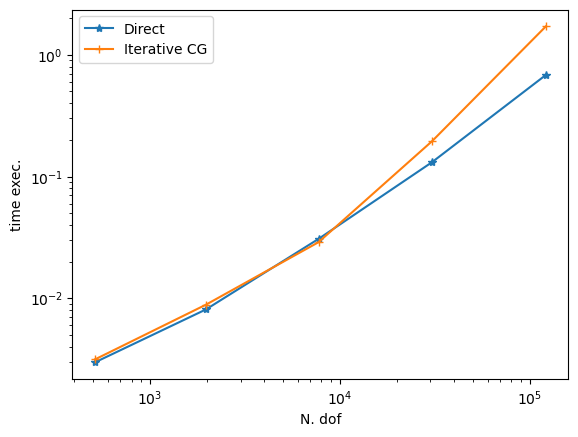

In [47]:
plt.xscale("log")
plt.yscale("log")
plt.plot(*zip(*time_direct), "-*")
plt.plot(*zip(*time_cg), "-+")
plt.legend(['Direct', 'Iterative CG'])
plt.xlabel('N. dof')
plt.ylabel('time exec.')
# plt.savefig('03_Module_Test2.png')
plt.show()

# from IPython.display import Image
# Image(filename='03_Module_Test2.png') 

In [48]:
_, _, steps = SolvePoissonIterativeCG_levels(h=paramt2['h0'], levels=paramt2['levels'], condense=False, compute_condnum=True)
ndofs = [steps[j][0] for j in range(len(steps))]
nsteps = [steps[j][1][0] for j in range(len(steps))]
kappas = [steps[j][1][1] for j in range(len(steps))]
import pandas as pd
tab = pd.DataFrame({'ndof':ndofs, 'time':np.asarray(time_cg)[:,1], 'Condition number':kappas, 'number of CG iterations': nsteps})
tab     

ndof = 514, time = 0.0050144195556640625, steps = (87, 547.5810182347417)
ndof = 1973, time = 0.010707855224609375, steps = (224, 3002.793817225276)
ndof = 7729, time = 0.027948856353759766, steps = (443, 7527.765444535608)
ndof = 30593, time = 0.1401212215423584, steps = (885, 15746.695304588135)
ndof = 121729, time = 1.6755666732788086, steps = (1776, 31446.87196375645)


,ndof,time,Condition number,number of CG iterations
0,514,0.003142,547.581018,87
1,1973,0.008848,3002.793817,224
2,7729,0.028875,7527.765445,443
3,30593,0.195060,15746.695305,885
4,121729,1.714837,31446.871964,1776
